# Change calculator

"The change-making problem is the problem of representing a given value with the fewest coins possible from a given set of coin denominations." A coin system is known as "canonical" if the change generated by a greedy algorithm is optimal for all amounts, otherwise it is known as "non-canonical". In a general case, the problem of providing a minimal set of coins is NP-hard, see this [paper](https://graal.ens-lyon.fr/%7Eabenoit/algo09/coins2.pdf) by David Pearson. 

This notebook has a Pyomo implementation of the coin change problem using integer programming. It is then used to test a given coin system for being canonic or non-canonic. Note that Pearson's check is much more efficient, as it is based on testing a set of potential counter-examples. See [this](https://stackoverflow.com/questions/13557979) great StackOverflow discussion for a JavaScript implementation of Pearson's algorithm. The [Wiki](https://en.wikipedia.org/wiki/Change-making_problem) is also very informative.

In [1]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def greedy_coin_change(amount: int, coin_dict: dict) -> dict:
    """
    Greedy algorithm for making change with coins.

    Args:
        amount (int): amount of money to make change for
        coin_dict (dict): dictionary of coin denominations

    Returns:
        dict: dictionary of count coins to give as change
    """

    coins = list(coin_dict.values())
    coin_dict = {v: k for k, v in coin_dict.items()}
    coins.sort(reverse=True)
    change = {}
    for coin in coins:
        change[coin_dict[coin]] = amount // coin
        amount = amount % coin
    return change

def milp_coin_change(amount: int, coin_dict: dict) -> dict:
    """
    Pyomo model for making change with coins.

    Args:
        amount (int): amount of money to make change for
        coin_dict (dict): dictionary of coin denominations
        solver (str): solver to use

    Returns:
        dict: dictionary of count coins to give as change
    """

    coins = list(coin_dict.values())
    coin_dict = {v: k for k, v in coin_dict.items()}
    coins.sort(reverse=True)
    model = pyo.ConcreteModel()
    model.coins = pyo.Set(initialize=coins)
    model.x = pyo.Var(model.coins, domain=pyo.NonNegativeIntegers)
    model.obj = pyo.Objective(expr=sum(model.x[c] for c in model.coins), sense=pyo.minimize)
    model.con = pyo.Constraint(expr=sum(model.x[c] * c for c in model.coins) == amount)
    solver = pyo.SolverFactory('cbc')
    solver.solve(model)
    return {coin_dict[c]: model.x[c]() for c in model.coins}

def coin_count(solution):
    """
    Count the number of coins in a solution.
    """
    return sum(solution.values())

def generate_coin_series(coin_dict, change_function, max_amount=None):
    """
    Generate a pandas Series representing the number of coins needed for each amount
    from 1 to double the highest coin denomination in the given coin dictionary.
    
    Parameters:
    coin_dict (dict): A dictionary where keys are coin names and values are their denominations.
    change_function (function): A function that takes an amount and a coin dictionary, and returns
                                the number of coins needed to make that amount.
    Returns:
    pd.Series: A pandas Series with the index ranging from 1 to double the highest coin denomination,
               and values corresponding to the number of coins needed for each amount.
    """

    if max_amount is None:
        max_amount = max(coin_dict.values()) * 2

    index_range = range(1, max_amount)
    coin_counts = [coin_count(change_function(amount, coin_dict)) for amount in index_range]
    return pd.Series(coin_counts, index=index_range, dtype=np.int32)

def compare_coin_systems(coin_dict1, coin_dict2, change_function1, change_function2, max_amount=None, coin_system_names=None):
    """
    Compare two coin systems using given change calculation functions.

    Args:
        coin_dict1 (dict): First coin dictionary.
        coin_dict2 (dict): Second coin dictionary.
        change_function1 (function): Function to calculate change for the first coin dictionary.
        change_function2 (function): Function to calculate change for the second coin dictionary.
        max_amount (int, optional): Maximum amount to consider. Defaults to double the highest coin denomination.
        coin_system_names (list, optional): List of two strings corresponding to the names of the coin systems. Defaults to ['Coin_System_1', 'Coin_System_2'].

    Returns:
        pd.DataFrame: DataFrame with index corresponding to the amount, and two columns corresponding to coin counts for the two input coin systems.
    """
    if max_amount is None:
        max_amount = max(max(coin_dict1.values()), max(coin_dict2.values())) * 2

    if coin_system_names is None:
        coin_system_names = ['Coin_System_1', 'Coin_System_2']

    coin_counts1 = generate_coin_series(coin_dict1, change_function1, max_amount)
    coin_counts2 = generate_coin_series(coin_dict2, change_function2, max_amount)

    df_comparison = pd.concat([coin_counts1, coin_counts2], axis=1)
    df_comparison.columns = coin_system_names

    return df_comparison

def is_canonical(coin_dict):
    """
    Check if a coin system is canonical using MILP.
    """

    for amount in range(1, max(coin_dict.values()) * 2):
        greedy_solution = greedy_coin_change(amount, coin_dict)
        pyomo_solution = milp_coin_change(amount, coin_dict)
        if coin_count(greedy_solution) != coin_count(pyomo_solution):
            return False
    return True

def plot_coin_system_comparison(df_comparison, title='Coin System Comparison'):
    """
    Plot a comparison between two coin systems.

    Args:
        df_comparison (pd.DataFrame): DataFrame with index corresponding to the amount, and two columns corresponding to coin counts for the two input coin systems.
    """

    columns = df_comparison.columns
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(df_comparison.index, df_comparison.iloc[:, 0], label=columns[0],
            marker='.', color='b', ms=10, alpha=0.75)
    ax.plot(df_comparison.index, df_comparison.iloc[:, 1], label=columns[1],
            marker='.', color='r', ms=10, alpha=0.75)
    # Show only major ticks on x-axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.set_xlabel('Amount')
    ax.set_ylabel('Number of Coins')
    ax.legend()
    ax.set_title(title)
    plt.show()

In [5]:
# US currency denominations - canonical example
coin_dict_us = {
    'penny': 1,
    'nickel': 5,
    'dime': 10,
    'quarter': 25,
}

# UK (pound sterling) currency denominations - non-canonical example thanks to the 25 pence coin
coin_dict_uk = {
    'penny': 1,
    'two_pence': 2,
    'five_pence': 5,
    'ten_pence': 10,
    'twenty_pence': 20,
    'twenty_five_pence': 25, # commemorative coin issued in four designs from 1977 to 1981 - rare but legal tender
    'fifty_pence': 50,
}

# UK pre 1971, omitting farthing and half-penny - non-canonical example
coin_dict_uk_old = {
    'penny': 1,
    'three_pence': 3,
    'six_pence': 6,
    'shilling': 12,
    'florin': 24,
    'half_crown': 30,
    'crown': 60
}

# Soviet Union (ruble) currency denominations - canonical example
coin_dict_ussr = {
    'kopek': 1,
    'two_kopek': 2,
    'three_kopek': 3,
    'five_kopek': 5,
    'ten_kopek': 10,
    'fifteen_kopek': 15,
    'twenty_kopek': 20,
    'fifty_kopek': 50,
}

# Non-canonical currency denominations - made up for illustrative purposes
coin_dict_noncanonic0 = {
    'A': 1,
    'B': 3,
    'C': 15,
    'D': 25,
}

# Non-canonical currency denominations - made up for illustrative purposes
coin_dict_noncanonic1 = {
    'A': 1,
    'B': 3,
    'C': 4,
}

## Example of Greedy algorithm failing

Using UK coins:

In [6]:
greedy_coin_change(40, coin_dict_uk)

{'fifty_pence': 0,
 'twenty_five_pence': 1,
 'twenty_pence': 0,
 'ten_pence': 1,
 'five_pence': 1,
 'two_pence': 0,
 'penny': 0}

In [7]:
milp_coin_change(40, coin_dict_uk)

{'fifty_pence': 0.0,
 'twenty_five_pence': 0.0,
 'twenty_pence': 2.0,
 'ten_pence': 0.0,
 'five_pence': 0.0,
 'two_pence': 0.0,
 'penny': 0.0}

## Comparing coin systems

Plotting minimal number of coins vs. given total value.

In [8]:
df_compare_us_uk_milp = compare_coin_systems(coin_dict_us, coin_dict_uk, 
                                     milp_coin_change, milp_coin_change, max_amount=100,
                                     coin_system_names=['US Coins', 'UK Coins'])

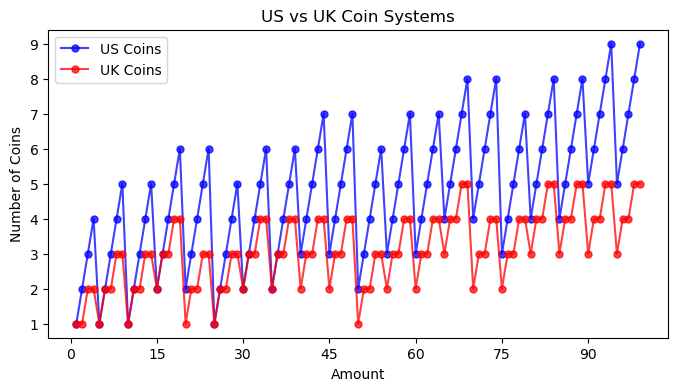

In [9]:
plot_coin_system_comparison(df_compare_us_uk_milp, title='US vs UK Coin Systems')

## Brute-force test if a coin system is canonic

Comparing MILP coin count with greedy count for sums up to double of the highest coin denomination.

In [10]:
print("Is the US coin system canonic?", is_canonical(coin_dict_us))
print("Is the USSR coin system canonic?", is_canonical(coin_dict_ussr))
print("Is the old UK coin system canonic?", is_canonical(coin_dict_uk_old))

Is the US coin system canonic? True
Is the USSR coin system canonic? True
Is the old UK coin system canonic? False


## Comparing MILP vs. Greedy coin counts for non-canonic examples

Comparing the old UK coin system.

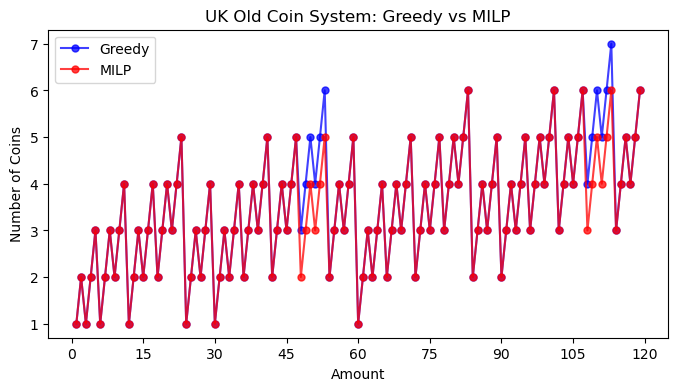

In [11]:
uk_old_coins_df = compare_coin_systems(coin_dict_uk_old, coin_dict_uk_old, 
                                     greedy_coin_change, milp_coin_change, max_amount=120,
                                     coin_system_names=['Greedy', 'MILP'])

plot_coin_system_comparison(uk_old_coins_df, title='UK Old Coin System: Greedy vs MILP')

Comparing modern UK coin system:

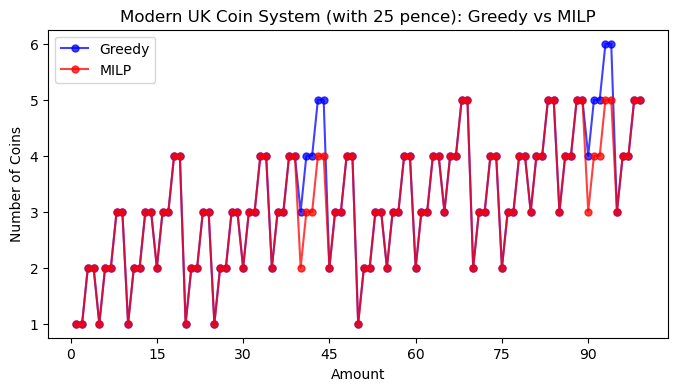

In [29]:
uk_coins_df = compare_coin_systems(coin_dict_uk, coin_dict_uk, 
                                     greedy_coin_change, milp_coin_change, max_amount=100,
                                     coin_system_names=['Greedy', 'MILP'])

plot_coin_system_comparison(uk_coins_df, title='Modern UK Coin System (with 25 pence): Greedy vs MILP')

Comparing non-canonic example 1

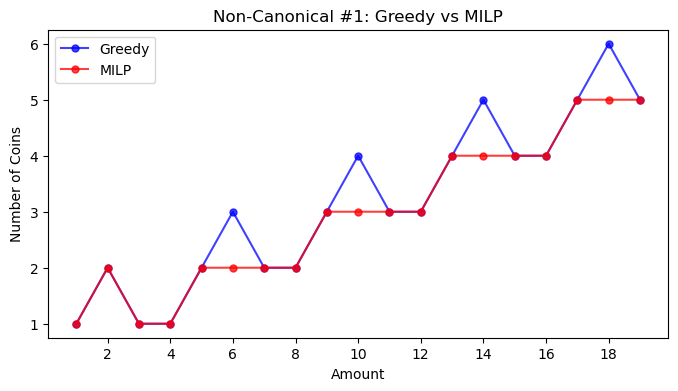

In [13]:
noncanonical1_coins_df = compare_coin_systems(coin_dict_noncanonic1, coin_dict_noncanonic1, 
                                     greedy_coin_change, milp_coin_change, max_amount=20,
                                     coin_system_names=['Greedy', 'MILP'])

plot_coin_system_comparison(noncanonical1_coins_df, title='Non-Canonical #1: Greedy vs MILP')

Comparing non-canonic example #0. The maximum gap between MILP and greedy count is 2 in this case. Can we make it bigger?

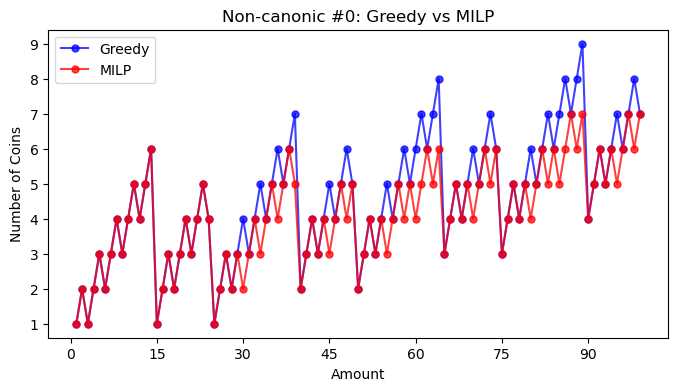

In [14]:
noncanonic0_coins_df = compare_coin_systems(coin_dict_noncanonic0, coin_dict_noncanonic0, 
                                     greedy_coin_change, milp_coin_change, max_amount=100,
                                     coin_system_names=['Greedy', 'MILP'])
plot_coin_system_comparison(noncanonic0_coins_df, title='Non-canonic #0: Greedy vs MILP')

In [24]:
def count_greedy_milp_diff(df):
    """
    Count the number of times the greedy algorithm gives a different number of coins than MILP.
    """

    df = df.copy()
    df['gap'] = df['Greedy'] - df['MILP']
    df = df.groupby('gap')[['gap']].count()
    df.columns = ['count']
    return df

count_greedy_milp_diff(noncanonic0_coins_df)

,count
gap,
0,77
2,22


We can increase the gap between MILP and greedy counts by multiplying all denominations except 1 by some integer.

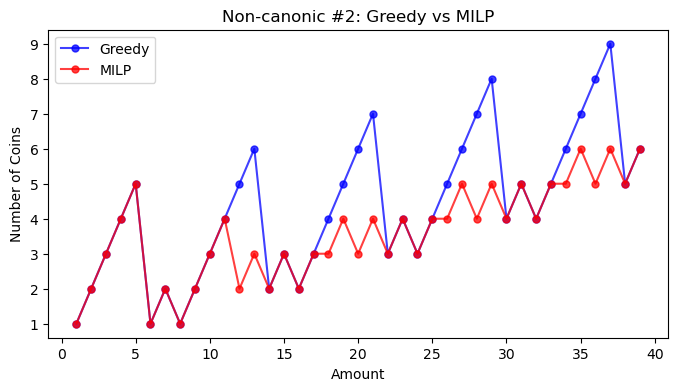

,count
gap,
0,25
1,6
3,8


In [25]:
coin_dict_noncanonic2 = {
    'A': 1,
    'B': 6,
    'C': 8,
}
noncanonic2_coins_df = compare_coin_systems(coin_dict_noncanonic2, coin_dict_noncanonic2, 
                                     greedy_coin_change, milp_coin_change, max_amount=40,
                                     coin_system_names=['Greedy', 'MILP'])
plot_coin_system_comparison(noncanonic2_coins_df, title='Non-canonic #2: Greedy vs MILP')
count_greedy_milp_diff(noncanonic2_coins_df)

In [27]:
milp_coin_change(13, coin_dict_noncanonic2)

{'C': 0.0, 'B': 2.0, 'A': 1.0}

In [28]:
greedy_coin_change(13, coin_dict_noncanonic2)

{'C': 1, 'B': 0, 'A': 5}

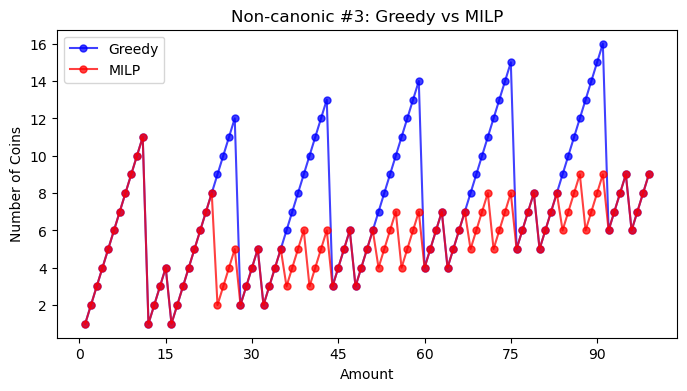

,count
gap,
0,63
3,16
7,20


In [26]:
coin_dict_noncanonic3 = {
    'A': 1,
    'B': 12,
    'C': 16,
}
noncanonic3_coins_df = compare_coin_systems(coin_dict_noncanonic3, coin_dict_noncanonic3, 
                                     greedy_coin_change, milp_coin_change, max_amount=100,
                                     coin_system_names=['Greedy', 'MILP'])
plot_coin_system_comparison(noncanonic3_coins_df, title='Non-canonic #3: Greedy vs MILP')
count_greedy_milp_diff(noncanonic3_coins_df)